# ghcperf report 

See https://github.com/teh/ghcperf for more details.

In [1]:
%matplotlib inline
import glob
import pandas
import json
import datetime

In [2]:
datetime.datetime.utcnow().isoformat()

'2016-03-10T14:03:12.065012'

First copy the data fro S3.

In [3]:
# Abuse /tmp as a cache so we don't do so many GETs
!mkdir -p /tmp/report-data
!aws s3 sync s3://ghcperf-results /tmp/report-data --no-sign-request --quiet
!find /tmp/report-data | wc

     48      48    5163


In [4]:
def parse_name(s):
    # Takes 
    # /tmp/report-data/5a494d8ec688e42601262913172f24cee7a36c9b/perf-1yjvliagav9mf7klzl4qjqs95iggv343-scientific-0.3.4.4.csv
    # returns
    # 5a494d8..., scientific-0.3.4.4
    parts = s.split('/')
    name = parts[4].split('-', 3)[2]
    sha = parts[3]
    return sha, name
def read(x):
    df = pandas.read_csv(x, skiprows=2, header=None, names=["value", "?", "name", "long_value", "?2"])
    sha, package = parse_name(x)
    df['sha'] = sha[:8]
    df['package'] = package
    with open('/tmp/report-data/' + sha + "/" + "commit_meta.json") as f:
        commit = json.load(f)
        df['timestamp'] = commit['committer']['date'] 
    return df

In [5]:
df = pandas.concat([read(x) for x in glob.glob('/tmp/report-data/*/*csv')], axis=0)
df.head()

,value,?,name,long_value,?2,sha,package,timestamp
0,10914.611874,NaN,task-clock,10914611874,100,374f9199,hashable,2016-03-09T22:11:57Z
1,13060,NaN,context-switches,10914611874,100,374f9199,hashable,2016-03-09T22:11:57Z
2,7200,NaN,cpu-migrations,10914611874,100,374f9199,hashable,2016-03-09T22:11:57Z
3,925697,NaN,page-faults,10914611874,100,374f9199,hashable,2016-03-09T22:11:57Z
4,<not supported>,NaN,cycles,0,100,374f9199,hashable,2016-03-09T22:11:57Z


In [6]:
df = df[(df.name == "task-clock")]
df['value'] = df['value'].astype('float')
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')

In [7]:
plot_df = df[df.package.isin(['aeson', 'text'])]\
    .groupby(['timestamp', 'sha', 'package'])\
    .value\
    .agg(['mean', 'median', 'std'])

# task-clock over time

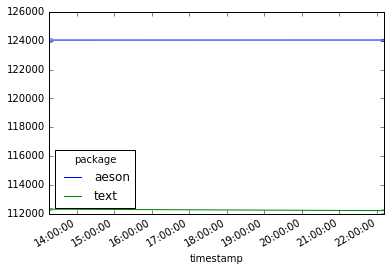

In [8]:
pdf = plot_df.unstack().reset_index(level=1, drop=True)
pdf['mean'].plot(yerr=pdf['std'])

In [9]:
plot_df

mean         median         std
timestamp           sha      package                                          
2016-03-09 13:16:13 5a494d8e aeson    124054.787897  124017.765628  120.770088
                             text     112309.488031  112286.952585   82.997220
2016-03-09 22:11:57 374f9199 aeson    124056.637195  124054.835207   53.562156
                             text     112209.365236  112228.105015  132.786385